# Cifar 10 classification performed using 5 Layer Conv Net with 2 Layer FC Net as Classifier

Accuracy achieved: 81.46 %

Features Implemented:
1. Data Augmentation
2. Training Convolutional Neural Network for feature extraction and simple 2 Layer Fully Connected Network as Classifier
    



# Settings to run on Google Colab

Stores the trained models in Google Drive

Comment the following out if running on your own system

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
path = 'gdrive/My Drive/Colab Notebooks/cifar10Project/'
os.listdir(path)

['dataset',
 'CNN_models',
 'DNN_models',
 'dog.png',
 'cifar10TransferLearning2.ipynb',
 '11_truck.png',
 '9993_dog.png',
 '85_dog.png',
 '1387_truck.png',
 'cifar10WebApp.ipynb',
 'cifar10TransferLearning.ipynb',
 'TransferLearning_models_Final',
 'TransferLearning_models',
 'cifar10DNN.ipynb',
 'cifar10CNN.ipynb',
 'cifar10TransferLearningFinal.ipynb',
 'cifar10CNN_Final.ipynb']

# Settings to run on your own system

Comment the following out if running on Google Drive

In [0]:
path = ''

In [0]:
# Sets width of jupyter notebook to full
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Folder Structure

Set up an empty folder called *TransferLearning_models* in your working directory(either on your system or on Google Drive) so that the trained models can be saved and accessed from this folder.

Below code prints folder structure in local device.

In [4]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
            
# currentDirectory = os.getcwd() # For working on own system
currentDirectory = path # For working on Google Colab

list_files(os.path.join(currentDirectory, 'CNN_models'))

CNN_models/
    bestESModel0.3.ckpt
    bestESModel0.4.ckpt
    ES/
        model1.ckpt


# 1. Importing Libraries 

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import PIL
import sys
import seaborn as sns
import sklearn.metrics
import pickle
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Checking if running on GPU or CPU 
# Will result in error if GPU is not available

#torch.cuda.set_device(1)
x=torch.Tensor(5,3)
print(x.cuda())

tensor([[2.4359e-36, 0.0000e+00, 3.7835e-44],
        [0.0000e+00,        nan, 0.0000e+00],
        [1.3733e-14, 6.4069e+02, 4.3066e+21],
        [1.1824e+22, 4.3066e+21, 6.3828e+28],
        [3.8016e-39, 1.0489e-08, 0.0000e+00]], device='cuda:0')


In [7]:
print(torch.__version__)

1.1.0


## 1.1 Data Augmentation and Loading the dataset

In [0]:
data_aug = True 
early_stopping = True

In [0]:
data_aug_transforms = []

if data_aug == True:

    data_aug_transforms = [
        transforms.RandomCrop((32,32), padding=4),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(15),
#         transforms.RandomAffine(degrees=0, translate=(.3,.7)),
#         transforms.ColorJitter(
#                 brightness=float(0.1*np.random.rand(1)),
#                 contrast=float(0.1*np.random.rand(1)),
#                 saturation=float(0.1*np.random.rand(1)),
#                 hue=float(0.1*np.random.rand(1))),
#         
#         transforms.Resize((224,224)),
        transforms.ColorJitter(hue=.25, saturation=.25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        transforms.RandomGrayscale(p=0.1)
                    ]

In [0]:
norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])

In [0]:
cifar_dataset = torchvision.datasets.CIFAR10(root=path+'dataset/',
                                           train=True,
                                           transform=norm_transform,
                                           download=False)

test_dataset = torchvision.datasets.CIFAR10(root=path+'dataset/',
                                          train=False,
                                          transform=test_transform)

# 2. Defining the model

In [0]:
class ConvNet(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, dropout):
        super(ConvNet, self).__init__()
            
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels=input_size, out_channels=hidden_layers[0], kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(hidden_layers[0]),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.ReLU(),
                    nn.Dropout2d(dropout),

                    nn.Conv2d(in_channels=hidden_layers[0], out_channels=hidden_layers[1], kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(hidden_layers[1]),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.ReLU(),
                    nn.Dropout2d(dropout),

                    nn.Conv2d(in_channels=hidden_layers[1], out_channels=hidden_layers[2], kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(hidden_layers[2]),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.ReLU(),
                    nn.Dropout2d(dropout),

                    nn.Conv2d(in_channels=hidden_layers[2], out_channels=hidden_layers[3], kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(hidden_layers[3]),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.ReLU(),
                    nn.Dropout2d(dropout),

                    nn.Conv2d(in_channels=hidden_layers[3], out_channels=hidden_layers[4], kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(hidden_layers[4]),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.ReLU(),
                    nn.Dropout2d(dropout)    )

        self.fc = nn.Sequential(
                    nn.Linear(hidden_layers[4], hidden_layers[5]),
                    nn.BatchNorm1d(hidden_layers[5]),
                    nn.ReLU(),

                    nn.Linear(hidden_layers[5], num_classes)
                        )

    def forward(self, x):
        
        x = self.conv(x)
        x = x.squeeze()
        out = self.fc(x)
        
        return out

## 2.1 Initializing the weights and updating the learning rate

In [0]:
def weights_init(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight.data, mean=0.0, std=1e-3)
        m.bias.data.fill_(0.0)
        
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data) 
        m.bias.data.fill_(0.0)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [0]:
def PrintModelSize(model, disp=True):
    model_sz = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Number of trainable parameters = ",model_sz)
    return model_sz

# 3. Training the model

## 3.1 Setting up the device and seed for reproducibility

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

Using device: cuda


In [16]:
n = 2
np.random.seed(n)
torch.cuda.manual_seed_all(n)
torch.manual_seed(n)

## 3.2 Model parameters

In [0]:
input_size = 3
num_classes = 10
hidden_size = [128, 512, 512, 512, 512, 512]
num_epochs = 70
batch_size = 200
learning_rate = 2e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000

In [0]:
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [0]:
dropoutVals = [i/10 for i in range(1,10)]

## 3.3 Training the model for multiple values of dropout

In [0]:
listOfAllLosses = []
listOfAllValAccs = []

testAcc = []
trainAcc = []

for dropout in dropoutVals :

    print("######################################################################")
    print("Current value of dropout is:", dropout)
    print("######################################################################")

    model = ConvNet(input_size, hidden_size, num_classes, dropout).to(device)
    model.apply(weights_init)
    
    # Print the model
    print(model)
    
    # Print model size
    PrintModelSize(model)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

    # Train the model
    lr = learning_rate
    total_step = len(train_loader)

    losses = []
    valAcc = []
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            loss = criterion(outputs, labels)
            losses.append(loss)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        # Code to update the lr
        lr *= learning_rate_decay
        update_lr(optimizer, lr)
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print('Validataion accuracy is: {} %'.format(100 * correct / total))
            best_model = None
        
            current_valAcc = 100 * correct / total
            valAcc.append(current_valAcc)

            if early_stopping == True:
                if current_valAcc >= np.amax(valAcc):
                    torch.save(model.state_dict(), path+'CNN_models/ES/model'+str(epoch+1)+'.ckpt')

        model.train()

    trainAcc.append(100 * correct / total)    
        
    
    # Test the model
    print('Testing .................')
    
    model.eval()
    if early_stopping == True:
        last_model = model
        best_id = np.argmax(valAcc)
        bestESmodel = ConvNet(input_size, hidden_size, num_classes, dropout).to(device)
        bestESmodel.load_state_dict(torch.load(path+'CNN_models/ES/model'+str(best_id+1)+'.ckpt'))
        bestESmodel.eval()
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = bestESmodel(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the best network on the {} test images: {} %'.format(total, 100 * correct / total))
        testAcc.append(100 * correct / total)
        if early_stopping: 
            print("Best Epoch: ", best_id+1)

            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = last_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                print('Accuracy of the last network on the {} test images: {} %'.format(total, 100 * correct / total))
    
    torch.save(bestESmodel.state_dict(), path+'CNN_models/bestESModel'+str(dropout)+'.ckpt')
    
    listOfAllLosses.append(losses)
    listOfAllValAccs.append(valAcc)

######################################################################
Current value of dropout is: 0.1
######################################################################
ConvNet(
  (conv): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout2d(p=0.1)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout2d(p=0.1)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride

Epoch [53/70], Step [100/245], Loss: 0.5052
Epoch [53/70], Step [200/245], Loss: 0.5045
Validataion accuracy is: 83.8 %
Epoch [54/70], Step [100/245], Loss: 0.4358
Epoch [54/70], Step [200/245], Loss: 0.4257
Validataion accuracy is: 82.7 %
Epoch [55/70], Step [100/245], Loss: 0.4229
Epoch [55/70], Step [200/245], Loss: 0.4833
Validataion accuracy is: 83.2 %
Epoch [56/70], Step [100/245], Loss: 0.4521
Epoch [56/70], Step [200/245], Loss: 0.4976
Validataion accuracy is: 83.1 %
Epoch [57/70], Step [100/245], Loss: 0.4234
Epoch [57/70], Step [200/245], Loss: 0.5143
Validataion accuracy is: 85.6 %
Epoch [58/70], Step [100/245], Loss: 0.4106
Epoch [58/70], Step [200/245], Loss: 0.3845
Validataion accuracy is: 85.1 %
Epoch [59/70], Step [100/245], Loss: 0.4495
Epoch [59/70], Step [200/245], Loss: 0.5047
Validataion accuracy is: 84.8 %
Epoch [60/70], Step [100/245], Loss: 0.4507
Epoch [60/70], Step [200/245], Loss: 0.4695
Validataion accuracy is: 84.4 %
Epoch [61/70], Step [100/245], Loss: 0.4

Validataion accuracy is: 79.0 %
Epoch [34/70], Step [100/245], Loss: 0.7701
Epoch [34/70], Step [200/245], Loss: 0.8562
Validataion accuracy is: 77.7 %
Epoch [35/70], Step [100/245], Loss: 0.6985
Epoch [35/70], Step [200/245], Loss: 0.8014
Validataion accuracy is: 78.9 %
Epoch [36/70], Step [100/245], Loss: 0.7322
Epoch [36/70], Step [200/245], Loss: 0.6647
Validataion accuracy is: 79.1 %
Epoch [37/70], Step [100/245], Loss: 0.7805
Epoch [37/70], Step [200/245], Loss: 0.7552
Validataion accuracy is: 81.1 %
Epoch [38/70], Step [100/245], Loss: 0.6855
Epoch [38/70], Step [200/245], Loss: 0.6626
Validataion accuracy is: 78.6 %
Epoch [39/70], Step [100/245], Loss: 0.6897
Epoch [39/70], Step [200/245], Loss: 0.7564
Validataion accuracy is: 80.6 %
Epoch [40/70], Step [100/245], Loss: 0.6919
Epoch [40/70], Step [200/245], Loss: 0.7491
Validataion accuracy is: 80.4 %
Epoch [41/70], Step [100/245], Loss: 0.7535
Epoch [41/70], Step [200/245], Loss: 0.6617
Validataion accuracy is: 81.3 %
Epoch [4

Epoch [14/70], Step [200/245], Loss: 1.0843
Validataion accuracy is: 65.7 %
Epoch [15/70], Step [100/245], Loss: 1.0897
Epoch [15/70], Step [200/245], Loss: 1.0581
Validataion accuracy is: 70.9 %
Epoch [16/70], Step [100/245], Loss: 1.2384
Epoch [16/70], Step [200/245], Loss: 1.0764
Validataion accuracy is: 68.7 %
Epoch [17/70], Step [100/245], Loss: 0.9707
Epoch [17/70], Step [200/245], Loss: 1.2051
Validataion accuracy is: 70.4 %
Epoch [18/70], Step [100/245], Loss: 1.1034
Epoch [18/70], Step [200/245], Loss: 1.0894
Validataion accuracy is: 71.4 %
Epoch [19/70], Step [100/245], Loss: 0.9963
Epoch [19/70], Step [200/245], Loss: 1.0378
Validataion accuracy is: 70.9 %
Epoch [20/70], Step [100/245], Loss: 1.2518
Epoch [20/70], Step [200/245], Loss: 1.0866
Validataion accuracy is: 72.3 %
Epoch [21/70], Step [100/245], Loss: 0.9527
Epoch [21/70], Step [200/245], Loss: 0.9050
Validataion accuracy is: 71.3 %
Epoch [22/70], Step [100/245], Loss: 1.0479
Epoch [22/70], Step [200/245], Loss: 0.9

Epoch [1/70], Step [100/245], Loss: 2.0190
Epoch [1/70], Step [200/245], Loss: 1.8144
Validataion accuracy is: 33.0 %
Epoch [2/70], Step [100/245], Loss: 1.8400
Epoch [2/70], Step [200/245], Loss: 1.7570
Validataion accuracy is: 43.2 %
Epoch [3/70], Step [100/245], Loss: 1.6327
Epoch [3/70], Step [200/245], Loss: 1.6586
Validataion accuracy is: 49.3 %
Epoch [4/70], Step [100/245], Loss: 1.5898
Epoch [4/70], Step [200/245], Loss: 1.7022
Validataion accuracy is: 47.5 %
Epoch [5/70], Step [100/245], Loss: 1.4982
Epoch [5/70], Step [200/245], Loss: 1.6282
Validataion accuracy is: 53.1 %
Epoch [6/70], Step [100/245], Loss: 1.5154
Epoch [6/70], Step [200/245], Loss: 1.5835
Validataion accuracy is: 54.7 %
Epoch [7/70], Step [100/245], Loss: 1.4722
Epoch [7/70], Step [200/245], Loss: 1.4539
Validataion accuracy is: 57.5 %
Epoch [8/70], Step [100/245], Loss: 1.4817
Epoch [8/70], Step [200/245], Loss: 1.2591
Validataion accuracy is: 56.8 %
Epoch [9/70], Step [100/245], Loss: 1.4345
Epoch [9/70],

Validataion accuracy is: 79.6 %
Epoch [70/70], Step [100/245], Loss: 0.8068
Epoch [70/70], Step [200/245], Loss: 0.7825
Validataion accuracy is: 77.8 %
Testing .................
Accuracy of the best network on the 10000 test images: 79.8 %
Best Epoch:  69
Accuracy of the last network on the 10000 test images: 79.4 %
######################################################################
Current value of dropout is: 0.5
######################################################################
ConvNet(
  (conv): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout2d(p=0.5)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d

Epoch [50/70], Step [200/245], Loss: 0.9792
Validataion accuracy is: 72.3 %
Epoch [51/70], Step [100/245], Loss: 0.9752
Epoch [51/70], Step [200/245], Loss: 1.0414
Validataion accuracy is: 73.4 %
Epoch [52/70], Step [100/245], Loss: 0.8982
Epoch [52/70], Step [200/245], Loss: 1.0506
Validataion accuracy is: 72.8 %
Epoch [53/70], Step [100/245], Loss: 1.0121
Epoch [53/70], Step [200/245], Loss: 0.9898
Validataion accuracy is: 72.7 %
Epoch [54/70], Step [100/245], Loss: 0.9206
Epoch [54/70], Step [200/245], Loss: 0.9334
Validataion accuracy is: 71.3 %
Epoch [55/70], Step [100/245], Loss: 1.1557
Epoch [55/70], Step [200/245], Loss: 1.1294
Validataion accuracy is: 73.7 %
Epoch [56/70], Step [100/245], Loss: 0.8392
Epoch [56/70], Step [200/245], Loss: 0.9346
Validataion accuracy is: 71.7 %
Epoch [57/70], Step [100/245], Loss: 0.9978
Epoch [57/70], Step [200/245], Loss: 1.0710
Validataion accuracy is: 72.6 %
Epoch [58/70], Step [100/245], Loss: 0.9548
Epoch [58/70], Step [200/245], Loss: 0.9

Epoch [31/70], Step [100/245], Loss: 1.4478
Epoch [31/70], Step [200/245], Loss: 1.3802
Validataion accuracy is: 58.6 %
Epoch [32/70], Step [100/245], Loss: 1.3463
Epoch [32/70], Step [200/245], Loss: 1.5528
Validataion accuracy is: 59.3 %
Epoch [33/70], Step [100/245], Loss: 1.3214
Epoch [33/70], Step [200/245], Loss: 1.4025
Validataion accuracy is: 61.5 %
Epoch [34/70], Step [100/245], Loss: 1.3116
Epoch [34/70], Step [200/245], Loss: 1.4950
Validataion accuracy is: 61.5 %
Epoch [35/70], Step [100/245], Loss: 1.3025
Epoch [35/70], Step [200/245], Loss: 1.4986
Validataion accuracy is: 59.8 %
Epoch [36/70], Step [100/245], Loss: 1.3247
Epoch [36/70], Step [200/245], Loss: 1.3795
Validataion accuracy is: 60.9 %
Epoch [37/70], Step [100/245], Loss: 1.3711
Epoch [37/70], Step [200/245], Loss: 1.4709
Validataion accuracy is: 60.8 %
Epoch [38/70], Step [100/245], Loss: 1.2733
Epoch [38/70], Step [200/245], Loss: 1.3084
Validataion accuracy is: 63.4 %
Epoch [39/70], Step [100/245], Loss: 1.1

Validataion accuracy is: 36.3 %
Epoch [12/70], Step [100/245], Loss: 1.8705
Epoch [12/70], Step [200/245], Loss: 1.8961
Validataion accuracy is: 36.2 %
Epoch [13/70], Step [100/245], Loss: 1.8628
Epoch [13/70], Step [200/245], Loss: 2.0536
Validataion accuracy is: 38.4 %
Epoch [14/70], Step [100/245], Loss: 1.8640
Epoch [14/70], Step [200/245], Loss: 1.8291
Validataion accuracy is: 37.8 %
Epoch [15/70], Step [100/245], Loss: 1.8878
Epoch [15/70], Step [200/245], Loss: 2.0046
Validataion accuracy is: 38.2 %
Epoch [16/70], Step [100/245], Loss: 1.8678
Epoch [16/70], Step [200/245], Loss: 1.8700
Validataion accuracy is: 37.5 %
Epoch [17/70], Step [100/245], Loss: 1.8411
Epoch [17/70], Step [200/245], Loss: 1.8885
Validataion accuracy is: 39.9 %
Epoch [18/70], Step [100/245], Loss: 1.8147
Epoch [18/70], Step [200/245], Loss: 1.7164
Validataion accuracy is: 39.2 %
Epoch [19/70], Step [100/245], Loss: 1.7852
Epoch [19/70], Step [200/245], Loss: 1.7724
Validataion accuracy is: 39.0 %
Epoch [2

Epoch [1/70], Step [100/245], Loss: 2.1855
Epoch [1/70], Step [200/245], Loss: 2.1298
Validataion accuracy is: 13.2 %
Epoch [2/70], Step [100/245], Loss: 2.1990
Epoch [2/70], Step [200/245], Loss: 2.1769
Validataion accuracy is: 13.6 %
Epoch [3/70], Step [100/245], Loss: 2.1518
Epoch [3/70], Step [200/245], Loss: 2.2163
Validataion accuracy is: 17.4 %
Epoch [4/70], Step [100/245], Loss: 2.1513
Epoch [4/70], Step [200/245], Loss: 2.1323
Validataion accuracy is: 18.2 %
Epoch [5/70], Step [100/245], Loss: 2.0372
Epoch [5/70], Step [200/245], Loss: 2.0757
Validataion accuracy is: 21.2 %
Epoch [6/70], Step [100/245], Loss: 2.1175
Epoch [6/70], Step [200/245], Loss: 2.1056
Validataion accuracy is: 23.9 %
Epoch [7/70], Step [100/245], Loss: 2.1185
Epoch [7/70], Step [200/245], Loss: 2.0841
Validataion accuracy is: 22.6 %
Epoch [8/70], Step [100/245], Loss: 2.1186
Epoch [8/70], Step [200/245], Loss: 2.0406
Validataion accuracy is: 25.5 %
Epoch [9/70], Step [100/245], Loss: 2.1082
Epoch [9/70],

Validataion accuracy is: 43.2 %
Epoch [70/70], Step [100/245], Loss: 1.7271
Epoch [70/70], Step [200/245], Loss: 1.8032
Validataion accuracy is: 42.0 %
Testing .................
Accuracy of the best network on the 10000 test images: 42.02 %
Best Epoch:  64
Accuracy of the last network on the 10000 test images: 42.75 %
######################################################################
Current value of dropout is: 0.9
######################################################################
ConvNet(
  (conv): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout2d(p=0.9)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool

Epoch [50/70], Step [200/245], Loss: 2.1333
Validataion accuracy is: 18.4 %
Epoch [51/70], Step [100/245], Loss: 2.1061
Epoch [51/70], Step [200/245], Loss: 2.1607
Validataion accuracy is: 17.0 %
Epoch [52/70], Step [100/245], Loss: 2.0819
Epoch [52/70], Step [200/245], Loss: 2.1237
Validataion accuracy is: 18.2 %
Epoch [53/70], Step [100/245], Loss: 2.1865
Epoch [53/70], Step [200/245], Loss: 2.1088
Validataion accuracy is: 16.8 %
Epoch [54/70], Step [100/245], Loss: 2.1451
Epoch [54/70], Step [200/245], Loss: 2.1007
Validataion accuracy is: 16.6 %
Epoch [55/70], Step [100/245], Loss: 2.2130
Epoch [55/70], Step [200/245], Loss: 2.1438
Validataion accuracy is: 17.4 %
Epoch [56/70], Step [100/245], Loss: 2.1556
Epoch [56/70], Step [200/245], Loss: 2.1172
Validataion accuracy is: 16.3 %
Epoch [57/70], Step [100/245], Loss: 2.1392
Epoch [57/70], Step [200/245], Loss: 2.1760
Validataion accuracy is: 18.1 %
Epoch [58/70], Step [100/245], Loss: 2.0674
Epoch [58/70], Step [200/245], Loss: 2.1

## 3.4 Visualizing the accuracy and loss curves

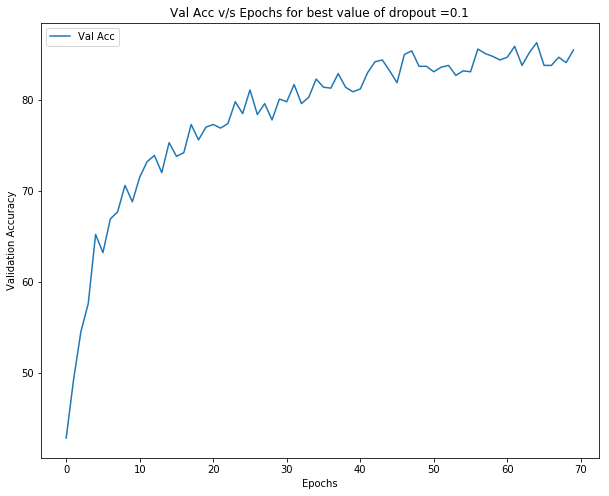

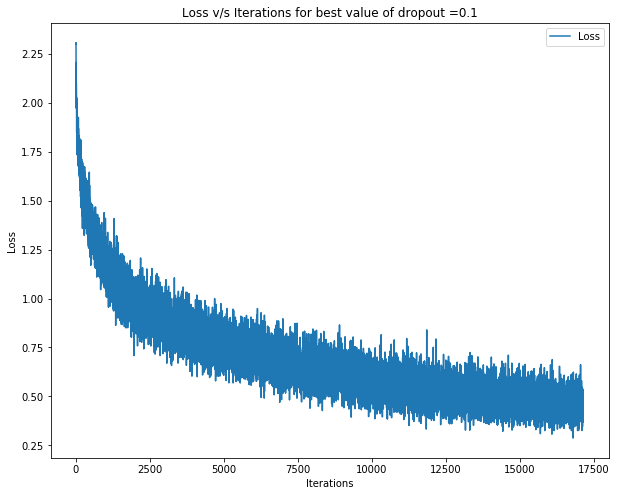

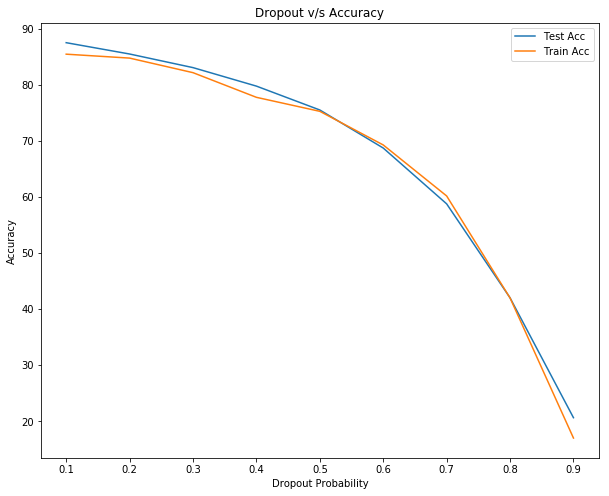

In [0]:
PosOfbestDropoutValue = np.argmax(testAcc)
plt.plot(listOfAllValAccs[PosOfbestDropoutValue], label = "Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title('Val Acc v/s Epochs for best value of dropout ='+str(dropoutVals[PosOfbestDropoutValue]))
plt.legend(loc="upper left")
plt.show()

plt.plot(listOfAllLosses[PosOfbestDropoutValue], label = "Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title('Loss v/s Iterations for best value of dropout ='+str(dropoutVals[PosOfbestDropoutValue]))
plt.legend(loc="upper right")
plt.show()

plt.plot(dropoutVals, testAcc, label = "Test Acc")
plt.plot(dropoutVals, trainAcc, label = "Train Acc")
plt.xlabel("Dropout Probability")
plt.ylabel("Accuracy")
plt.title('Dropout v/s Accuracy')
plt.legend(loc="upper right")
plt.show()

# 4. Visualizing the Filters

In [0]:
def VisualizeFilter(model, superTitle):
    
    tensor = torch.ones(model.conv[0].weight.data.size())
    tensor = model.conv[0].weight.clone().detach().requires_grad_(False)
    tensor = tensor.permute(0, 2, 3, 1) 
    tensor = tensor.cpu().data.numpy()
    
    t_max = np.amax(tensor)
    t_min = np.amin(tensor)

    tensor = (tensor - t_min) / (t_max - t_min) 

    num_cols = 16
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    fig.set_facecolor("black")

    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i],)
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    
    fig.suptitle(superTitle, color='white')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

## 4.1 Before training

In [0]:
modelBeforeTraining = ConvNet(input_size, hidden_size, num_classes, dropoutVals[PosOfbestDropoutValue]).to(device)
modelBeforeTraining.apply(weights_init)
print(modelBeforeTraining)
PrintModelSize(modelBeforeTraining)

ConvNet(
  (conv): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout2d(p=0.9)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout2d(p=0.9)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
    (14): Dropout2d(p=0.9)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16):

7946506

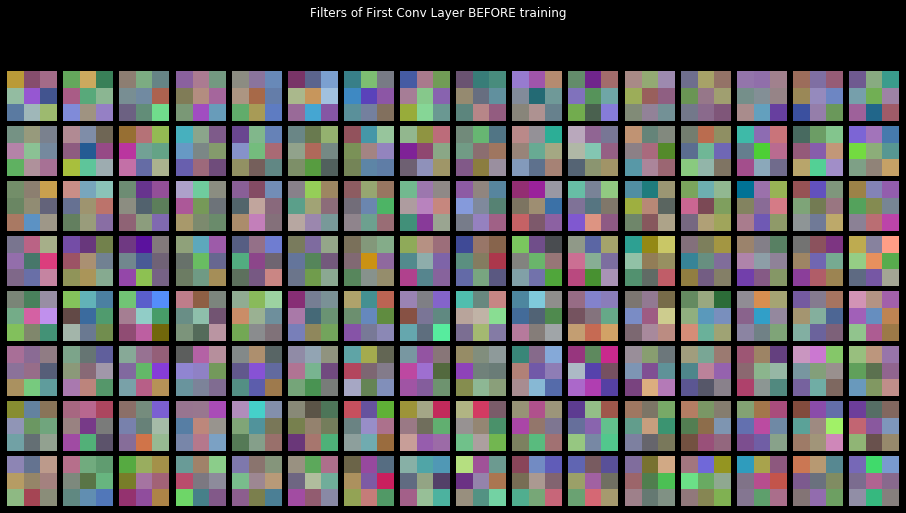

In [37]:
superTitle = 'Filters of First Conv Layer BEFORE training'
VisualizeFilter(modelBeforeTraining, superTitle)

## 4.2 After Training

In [0]:
bestDropoutModel = ConvNet(input_size, hidden_size, num_classes,  dropoutVals[PosOfbestDropoutValue]).to(device)
bestDropoutModel.load_state_dict(torch.load(path+'CNN_models/bestESModel'+str(dropoutVals[PosOfbestDropoutValue])+'.ckpt'))

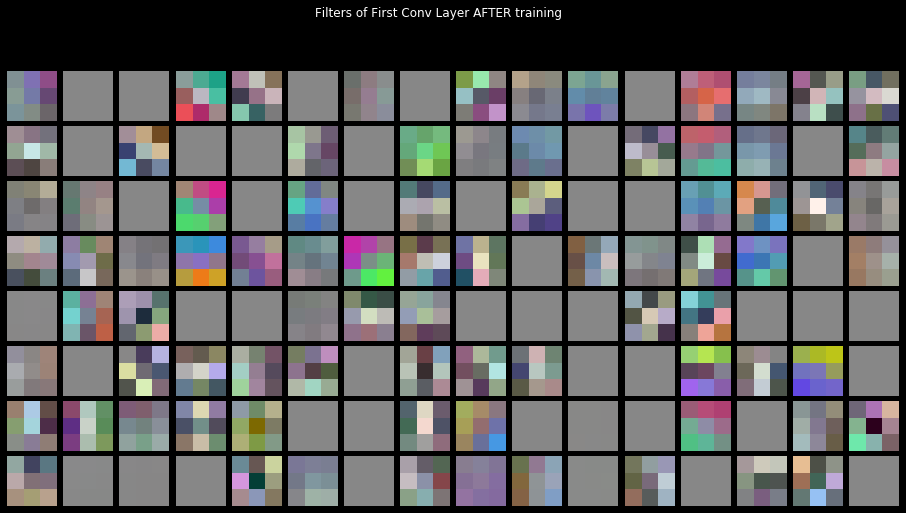

In [22]:
superTitle = 'Filters of First Conv Layer AFTER training'
VisualizeFilter(bestDropoutModel, superTitle)

# 5. Analyzing classification results

In [0]:
def getLabels(dataset):
    labels = []
    for i in range(len(dataset)):
        labels.append(dataset[i][1])
    return labels

def run_testing_labels(model, test_loader):

    # Test the model
    with torch.no_grad():
        correct = 0
        total = 0
        allPredLabels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _ , predicted = torch.max(outputs, 1)
            allPredLabels.append(predicted)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        testAcc = 100 * correct / total
        print('Accuracy of the network on the {} test images: {} %'.format(total, testAcc))
        
        return testAcc, allPredLabels
    

In [0]:
def display_classification_results(y_test, y_pred, labelNames,title="Accuracy Heatmap",show_report=True):
    
    print("Test accuracy: %.2f%%"%(sklearn.metrics.accuracy_score(y_test, y_pred)*100))
    
    if show_report:
        print("Classification Report:\n",sklearn.metrics.classification_report(y_test, y_pred))
    
    conf_mat = sklearn.metrics.confusion_matrix(y_test,y_pred)
    print("Confusion Matrix:\n",conf_mat)
    
    plt.rcParams['figure.figsize'] = (10.0, 8.0)
    ax = sns.heatmap(conf_mat, xticklabels=labelNames, yticklabels=labelNames, annot=True, fmt="d", cbar_kws={'label': 'Num Correct'})
    ax.set(title=title, xlabel="Actual Classes", ylabel="Predicted Classes")

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [30]:
metaDataPath = path+'dataset/cifar-10-batches-py/batches.meta'
metaData = unpickle(metaDataPath)
label_names_bin = 'label_names'.encode('utf-8')
labelNames = metaData[label_names_bin]
labelNames = [x.decode() for x in labelNames]
labelNames

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [0]:
testLabels = getLabels(test_dataset)

In [39]:
_, bestModelPreds = run_testing_labels(bestDropoutModel, test_loader)
bestModelPreds = [i.tolist() for i in bestModelPreds]
bestModelPreds = [item for sublist in bestModelPreds for item in sublist]

Accuracy of the network on the 10000 test images: 81.46 %


Test accuracy: 81.46%
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.84      1000
           1       0.91      0.92      0.91      1000
           2       0.78      0.69      0.74      1000
           3       0.67      0.68      0.67      1000
           4       0.78      0.78      0.78      1000
           5       0.77      0.76      0.76      1000
           6       0.85      0.86      0.86      1000
           7       0.83      0.85      0.84      1000
           8       0.88      0.89      0.88      1000
           9       0.88      0.86      0.87      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

Confusion Matrix:
 [[871   6  27   6   7   2   4  10  49  18]
 [ 12 917   2   4   1   1   4   0  16  43]
 [ 52   4 693  62  70  38  38  34   4   5]
 [ 21   7  45 676  47 117  32  28  13  14]
 [ 2

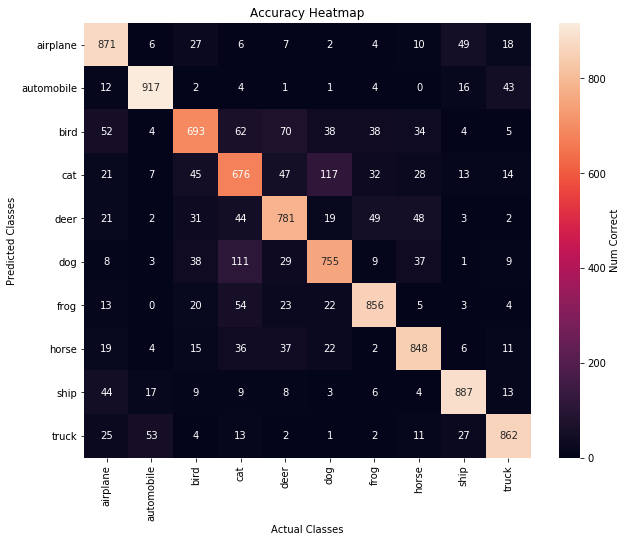

In [40]:
display_classification_results(testLabels, bestModelPreds,labelNames , title="Accuracy Heatmap",show_report=True)

In [0]:
torch.save(bestDropoutModel.state_dict(), path+'CNN_models/absoluteBestESModel'+str(dropoutVals[PosOfbestDropoutValue])+'.ckpt')
print('Filename of absolute best CNN model is: ')
print(path+'CNN_models/absoluteBestESModel'+str(dropoutVals[PosOfbestDropoutValue])+'.ckpt')

Filename of absolute best CNN model is: 
CNN_models/absoluteBestESModel0.1.ckpt
